# Analyzing national anthems 
*Project by Monika Kaczan for the Text Mining & Social Media Mining class*

## Introduction

In this project our goal is to analyze national anthems in different countries of the world. We will mainly focus on relationships between anthems: we will attempt to clusterize them and explore topics appearing in them. To do that, we will use K-means and aglomerative clustering and LDA. We will also try to check the sentiment appearing in the anthems.


## Data & preliminary analysis

The dataset we used comes from kaggle (https://www.kaggle.com/datasets/lucasturtle/national-anthems-of-the-world). The data contains lyrics of 190 national anthems translated into English. Therefore the dataset covers practically every country in the World. 

In [1]:
# Loading nessesary libraries

import pandas as pd 
import numpy as np 
import seaborn as sns
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE

from wordcloud import WordCloud
from wordcloud import STOPWORDS

import nltk
import re
import os
import codecs
from sklearn import feature_extraction

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Uploading the dataset

raw_data = pd.read_csv("anthems.csv")
data = raw_data.loc[:, ['Country', 'Continent', 'Anthem']]
data = data.set_index('Country', drop = False)

data.head(10)

,Country,Continent,Anthem
Country,,,
Albania,Albania,Europe,"Around our flag we stand united, With one wish..."
Armenia,Armenia,Europe,"Our Fatherland, free, independent, That has fo..."
Austria,Austria,Europe,"Land of mountains, land by the river, Land of ..."
Azerbaijan,Azerbaijan,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
Belarus,Belarus,Europe,"We, Belarusians, are peaceful people, Wholehea..."
Belgium,Belgium,Europe,"O dear Belgium, O holy land of the fathers Ã¢â..."
Bosnia and Herzegovina,Bosnia and Herzegovina,Europe,You're the light of the soul Eternal fire's fl...
Bulgaria,Bulgaria,Europe,"Proud Balkan Mountains, next to it the Danube ..."
Croatia,Croatia,Europe,"Our beautiful homeland, Oh so fearless and gra..."


In [3]:
# Cleaning the text of anthems. We also use lemmatization to group together the different inflected forms of words.

word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?^_`'
lemmatizer = WordNetLemmatizer()

def clean_anthem(anthem, bigrams = False):
    anthem = anthem.lower() # lower case
    anthem = re.sub('['+my_punctuation + ']+', ' ', anthem) # strip punctuation
    anthem = re.sub('\s+', ' ', anthem) #remove double spacing
    anthem = lemmatizer.lemmatize(anthem) #lemmatization
    return anthem

# Let's keep original text of anthem.
data['OriginalAnthem'] = data.Anthem

data['Anthem'] = data.Anthem.apply(clean_anthem)
data.head(10)

,Country,Continent,Anthem,OriginalAnthem
Country,,,,
Albania,Albania,Europe,around our flag we stand united with one wish ...,"Around our flag we stand united, With one wish..."
Armenia,Armenia,Europe,our fatherland free independent that has for c...,"Our Fatherland, free, independent, That has fo..."
Austria,Austria,Europe,land of mountains land by the river land of fi...,"Land of mountains, land by the river, Land of ..."
Azerbaijan,Azerbaijan,Europe,azerbaijan azerbaijan the glorious fatherland ...,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
Belarus,Belarus,Europe,we belarusians are peaceful people wholehearte...,"We, Belarusians, are peaceful people, Wholehea..."
Belgium,Belgium,Europe,o dear belgium o holy land of the fathers ã¢â‚...,"O dear Belgium, O holy land of the fathers Ã¢â..."
Bosnia and Herzegovina,Bosnia and Herzegovina,Europe,you re the light of the soul eternal fire s fl...,You're the light of the soul Eternal fire's fl...
Bulgaria,Bulgaria,Europe,proud balkan mountains next to it the danube s...,"Proud Balkan Mountains, next to it the Danube ..."
Croatia,Croatia,Europe,our beautiful homeland oh so fearless and grac...,"Our beautiful homeland, Oh so fearless and gra..."


Now let's find words that which are the most frequent among all the anthems.

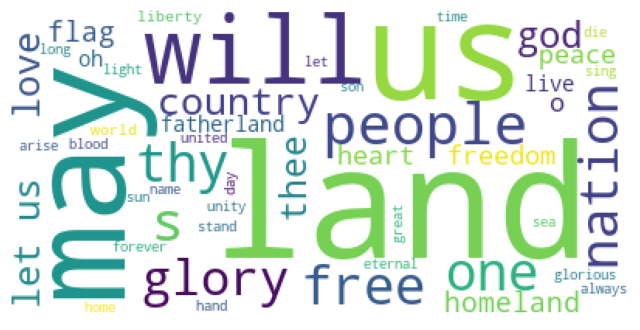

In [4]:
stopwords = set(STOPWORDS)
words = ' '.join(data['Anthem'])
cleaned_words = " ".join([word for word in words.split()])

stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords = stopwords,
                          background_color = 'white',
                          max_words = 50  
                          ).generate(cleaned_words)

plt.figure(1, figsize = (8, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Topic modelling

Let's start with exploring topics appearing in the anthems. We can expect that they will mainly concern patriotism, fight for one's country etc. but maybe we will find some other interesting themes? To find topics relating to anthems we will use Latent Dirichlet Allocation (LDA) algorithm.

#### LDA

Latent Dirichlet Allocation (LDA) is an iterative algorithm identifying a set of topics related to a set of documents. In LDA we asssume that a document is characterized by a distribution of topics while a topic is characterized by a distribution of words. We assign each word in the document to one of the identified topics and then based on their frequency we predict the topic of a whole document.

In [5]:
# We are creating vocabulary of all the words in our data with stopwords removed. We only include those words that appear in
# less than 80% of the anthem and appear in at least 3 anthems (2 anthems would give a vocabulary of 1340 words).

from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df = 0.8, min_df = 3, stop_words='english')
doc_term_matrix = count_vect.fit_transform(data['Anthem'].values.astype('U'))

In [6]:
doc_term_matrix

# We have 190 anthems and vocabulary of 801 words.

<190x801 sparse matrix of type '<class 'numpy.int64'>'
	with 6584 stored elements in Compressed Sparse Row format>

In [7]:
# We use LDA to create topics along with the probability distribution for each word in our vocabulary for each topic. 
# For starters, we will try 5 topics (and set random state) while keeping default values for all other parametrs.

from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components = 5, random_state = 1000)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=1000)

In [8]:
# We find 10 words with highest probabilities for all the five topics

for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['world', 'homeland', 'light', 'thousand', 'salute', 'fatherland', 'thy', 'thee', 'shall', 'god']


Top 10 words for topic #1:
['fatherland', 'live', 'shall', 'land', 'arms', 'free', 'blood', 'death', 'glory', 'homeland']


Top 10 words for topic #2:
['nation', 'peace', 'free', 'let', 'people', 'god', 'thee', 'love', 'thy', 'land']


Top 10 words for topic #3:
['ancestors', 'oh', 'long', 'glory', 'let', 'africa', 'live', 'flag', 'people', 'country']


Top 10 words for topic #4:
['shall', 'glorious', 'sing', 'song', 'nation', 'hail', 'liberty', 'die', 'freedom', 'let']




The topics seem to be pretty similiar. However we can try to distinguish some slight differences between them, for example:
- Topic no. 2 might talk about peace and freedom of the nation, so those would be anthems with independence themes
- Topic no. 4 seems to concern freedom and liberties and it does it in a 'singing' way. Those could be anthems focused on freedoms

However, those are just loose connections. To choose the optimal number of topics as well as the value of learning decay parameter we will use Log Likelihood Score. 

In [9]:
search_params = {
  'n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'learning_decay': [.5, .7]
}

model = LatentDirichletAllocation(random_state = 1000)

# Try all of the options
gridsearch = GridSearchCV(model, param_grid = search_params, n_jobs = -1, verbose=1)
gridsearch.fit(doc_term_matrix)

# What did we find?
print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 2}
Best Log Likelihood Score:  -12908.687885613006


In [10]:
results = pd.DataFrame(gridsearch.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.181599,0.045794,0.022599,0.006151,0.5,2,"{'learning_decay': 0.5, 'n_components': 2}",-11641.670638,-19237.809123,-9924.041413,-11840.915852,-11899.002402,-12908.687886,3247.485944,1
1,1.289000,0.287200,0.027803,0.007086,0.5,3,"{'learning_decay': 0.5, 'n_components': 3}",-12343.079457,-19948.090789,-10633.542926,-12517.558336,-12563.082470,-13601.070796,3253.454954,3
2,1.480802,0.093072,0.042601,0.006467,0.5,4,"{'learning_decay': 0.5, 'n_components': 4}",-12959.431022,-20691.070494,-11233.939214,-13111.370731,-13138.999870,-14226.962266,3309.916140,5
3,1.188999,0.112658,0.027200,0.006616,0.5,5,"{'learning_decay': 0.5, 'n_components': 5}",-13485.154564,-21295.249135,-11746.961184,-13582.813561,-13645.631727,-14751.162034,3347.844353,7
4,1.012596,0.117794,0.027198,0.006114,0.5,6,"{'learning_decay': 0.5, 'n_components': 6}",-14022.215863,-21959.817925,-12244.947773,-14116.283137,-14054.129552,-15279.478850,3413.810903,9


So the results of LDA are rather disappointing: the optimal solution is just two topics. Let's investigate them.

In [11]:
# LDA for 2 topics with learning_decay' of 0.5.

LDA = LatentDirichletAllocation(n_components = 2, random_state = 1000)
LDA.fit(doc_term_matrix)

for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['nation', 'love', 'people', 'shall', 'free', 'thee', 'thy', 'let', 'god', 'land']


Top 10 words for topic #1:
['free', 'glorious', 'flag', 'freedom', 'die', 'homeland', 'country', 'people', 'glory', 'land']




The topics make sense: the first one is about love of the nation and its people, while the second one stresses the importance of glory and freedoms. Nevertheless, they are pretty similiar.

In [12]:
# We can add a column to the original data frame that will store the topic.

topic_values = LDA.transform(doc_term_matrix)
data['Topic'] = topic_values.argmax(axis=1)
data.head(10)

,Country,Continent,Anthem,OriginalAnthem,Topic
Country,,,,,
Albania,Albania,Europe,around our flag we stand united with one wish ...,"Around our flag we stand united, With one wish...",1
Armenia,Armenia,Europe,our fatherland free independent that has for c...,"Our Fatherland, free, independent, That has fo...",1
Austria,Austria,Europe,land of mountains land by the river land of fi...,"Land of mountains, land by the river, Land of ...",0
Azerbaijan,Azerbaijan,Europe,azerbaijan azerbaijan the glorious fatherland ...,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",0
Belarus,Belarus,Europe,we belarusians are peaceful people wholehearte...,"We, Belarusians, are peaceful people, Wholehea...",1
Belgium,Belgium,Europe,o dear belgium o holy land of the fathers ã¢â‚...,"O dear Belgium, O holy land of the fathers Ã¢â...",0
Bosnia and Herzegovina,Bosnia and Herzegovina,Europe,you re the light of the soul eternal fire s fl...,You're the light of the soul Eternal fire's fl...,0
Bulgaria,Bulgaria,Europe,proud balkan mountains next to it the danube s...,"Proud Balkan Mountains, next to it the Danube ...",0
Croatia,Croatia,Europe,our beautiful homeland oh so fearless and grac...,"Our beautiful homeland, Oh so fearless and gra...",0


## Clustering

We will use clusterization to check whether there are maybe some distinctive types of anthems e.g. exploring certain themes. To do that, we will use k-means and agglomerative clustering.


#### K-means

In k-means clustering we aim to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster.

In [13]:
# To clusterize the data we first need to calculate term frequencies times inverse document frequency. To do this, we 
# divide the number of of occurrences for each word by total number of words assigning less value to unimportant stop words.

tfidf = TfidfVectorizer(
    min_df = 0.05,
    max_features = 2500,
    stop_words = 'english'
)
tfidf.fit(data.Anthem)
text = tfidf.transform(data.Anthem)

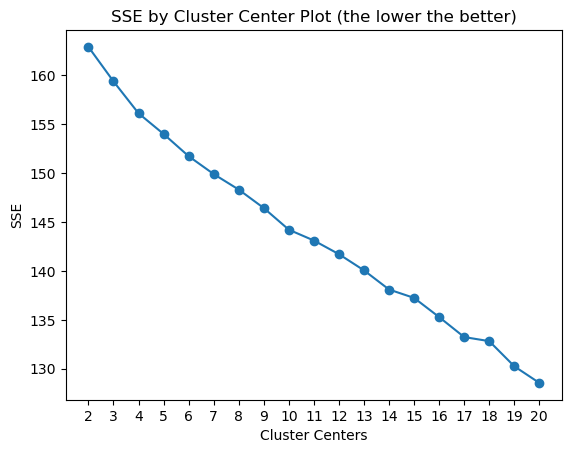

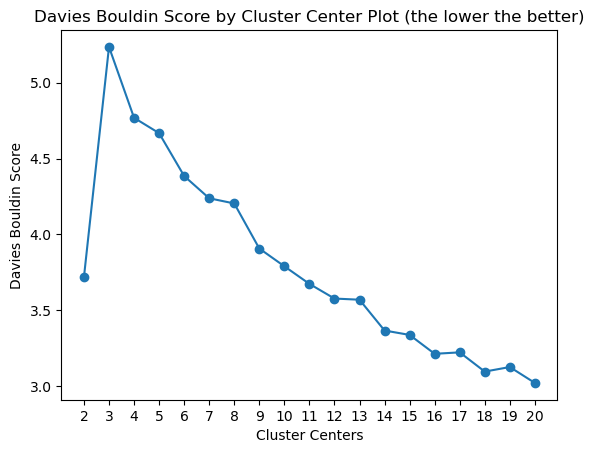

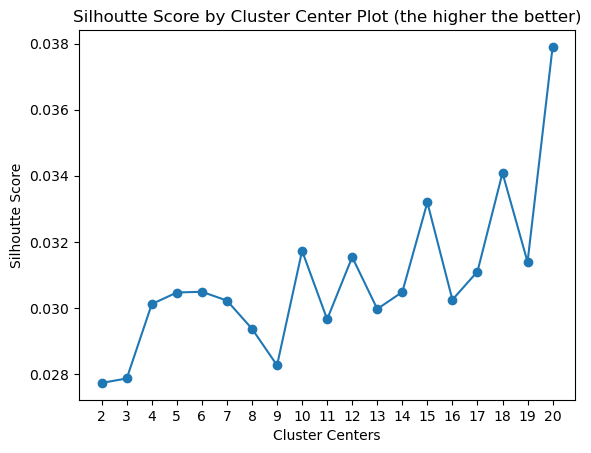

In [14]:
# To determine optimal number of clusters, we will use SSE, Davies Bouldin Score and Silhoutte Score.

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    dbi = []
    ss = []
    for k in iters:
        kmeans = KMeans(n_clusters = k, random_state = 100).fit(data)
        pred_labels = kmeans.labels_
        sse.append(kmeans.inertia_)
        dbi.append(metrics.davies_bouldin_score(data.toarray(), pred_labels))
        ss.append(metrics.silhouette_score(data.toarray(), pred_labels , metric='euclidean'))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot (the lower the better)')
    
    f2, ax2 = plt.subplots(1, 1)
    ax2.plot(iters, dbi, marker='o')
    ax2.set_xlabel('Cluster Centers')
    ax2.set_xticks(iters)
    ax2.set_xticklabels(iters)
    ax2.set_ylabel('Davies Bouldin Score')
    ax2.set_title('Davies Bouldin Score by Cluster Center Plot (the lower the better)')
    
    f3, ax3 = plt.subplots(1, 1)
    ax3.plot(iters, ss, marker='o')
    ax3.set_xlabel('Cluster Centers')
    ax3.set_xticks(iters)
    ax3.set_xticklabels(iters)
    ax3.set_ylabel('Silhoutte Score')
    ax3.set_title('Silhoutte Score by Cluster Center Plot (the higher the better)')
    

find_optimal_clusters(text, 20)

It is hard to draw one definite conclusion regarding number of clusters from those metrics. Moreover, Silhouette scores are barerly above 0 which suggest that clusters are overlapping. It could be predicted as generally anthems explore similair themes and thus use similiar vocabulary.

Nevertheless, based on the graphs above, I believe that clustering data into 4 clusters would be the most reasonable. We can try it and check whether results will make some sense.

In [15]:
clusters = KMeans(n_clusters = 4, random_state = 100).fit(text)

# Check how many obs. are in each cluster
data['labels'] = clusters.labels_
data['labels'].value_counts()

1    69
2    55
0    42
3    24
Name: labels, dtype: int64

In [16]:
# We can check clustering performance by comparing most popular words in each cluster - do they differ? Or are they all very 
# simiar in terms of words and their frequency?

def word_cloud(data, cluster):
    
    stopword_list = set(STOPWORDS) 

    word_cloud = WordCloud(width = 800, height = 500, 
                           background_color ='white', 
                           stopwords = stopword_list, 
                           min_font_size = 14,
                           max_words = 50).generate(data) 

    plt.figure(figsize = (8, 6)) 
    plt.title(cluster)
    plt.imshow(word_cloud) 
    plt.axis("off")  
    plt.show()

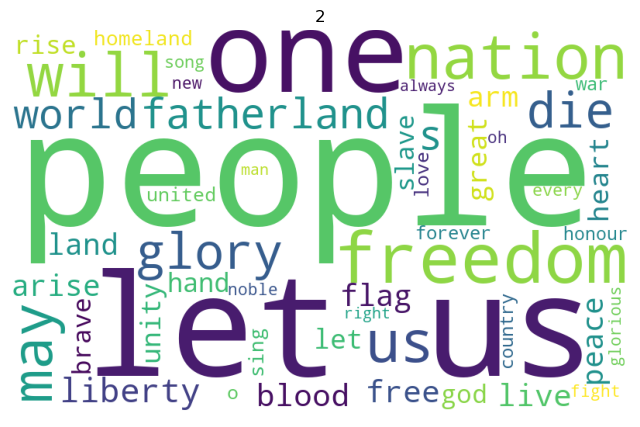

Albania Armenia Estonia France Georgia Germany Italy Netherlands (the) Portugal Romania Argentina Bolivia Chile Colombia Ecuador Paraguay Uruguay Venezuela Mexico Cuba Haiti Dominican Republic El Salvador Panama Barbados Australia Solomon Islands Samoa Kiribati China Iran Kyrgyzstan Laos Macau Maldives Mongolia Myanmar North Korea Singapore Thailand Turkey Turkmenistan Vietnam Yemen Algeria Angola Burkina Faso Burundi Cape Verde Central African Republic Chad Comoros Democratic Republic of Congo Equatorial Guinea Eritrea Ethiopia Gabon Gambia Guinea Kenya Mali Mozambique Niger Nigeria Republic of the Congo Sao Tome and Principe Senegal Tunisia Western Sahara


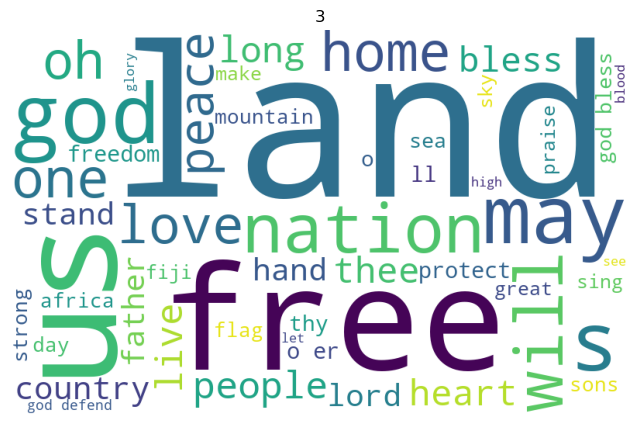

Austria Czechia Finland Ireland Latvia Luxembourg Malta Moldova (the Republic of) Norway Poland Slovakia Slovenia Sweden United Kingdom of Great Britain and Northern Ireland (the) Guyana Suriname United States of America Guatemala Jamaica Trinidad and Tobago Belize Saint Lucia Grenada Papua New Guinea New Zealand Fiji Vanuatu Federated States of Micronesia Tonga Afghanistan Brunei Indonesia Israel Japan Malaysia Nepal Oman Pakistan Palestine Qatar South Korea Botswana Lesotho Liberia Libya Malawi Saint Helena Somalia South Africa South Sudan Sudan Tanzania Uganda Zambia Zimbabwe


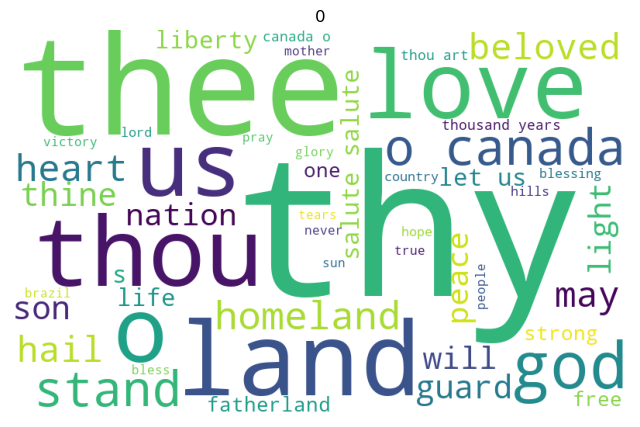

Azerbaijan Cyprus Greece Iceland Serbia Switzerland Brazil Canada Nicaragua Antigua and Barbuda Dominica Bangladesh India Philippines Sri Lanka Cameroon Egypt Ghana Ivory Coast Madagascar Mauritius Sierra Leone Swaziland Togo


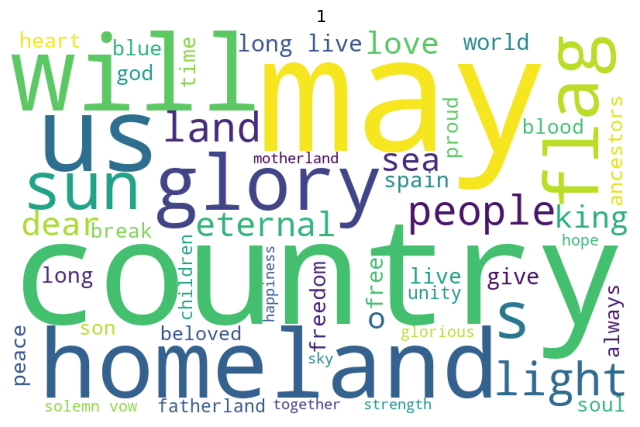

Belarus Belgium Bosnia and Herzegovina Bulgaria Croatia Denmark Hungary Liechtenstein Lithuania Montenegro Republic of North Macedonia Russian Federation (the) Spain Ukraine Peru Honduras Costa Rica Puerto Rico Bahamas Bermuda Greenland Bahrain Bhutan Cambodia Iraq Jordan Kazakhstan Kuwait Lebanon Saudi Arabia Syria Tajikistan United Arab Emirates Uzbekistan Benin Djibouti Guinea-Bissau Mauritania Morocco Namibia Rwanda Seychelles


In [17]:
for i in data.labels.unique():
    title = data.labels.unique()[i]
    new_df = data[data.labels == i]
    text = "".join(new_df.Anthem.tolist())
    word_cloud(text, title)
    print(*new_df.Country)

We see that in all clusters similiar words are frequent: 'us', 'country', 'nation'. However, I would argue that we can draw some (maybe not very certain but still) insights about these clusters. For example,
- Cluster 0 is full of old words such as 'thee' 'thy', 'thou'. Those could be anthems written in older language and urging other ('you') to take action.
- Anthems in cluster 2 stress the importance of personal freedoms and the power of a country coming from its people. 
- Clusters 1 and 3 seem to be pretty similiar.


#### Agglomerative clustering

Agglomerative clustering is a type of hierarchival clustering in which we treat each data as a singleton cluster at the outset and then successively agglomerates pairs of clusters until all clusters have been merged into a single cluster that contains all data. Similiar, but reverse procedure called divisive clustering could be also considered. Hierarchical clustering enables us to see how close are different observations to each other.

The code was inspired by: https://notebook.community/donaghhorgan/COMP9033/labs/09b%20-%20Agglomerative%20clustering

In [18]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [19]:
X = data['Anthem']

# Construct a pipeline: TF-IDF -> Sparse to Dense -> Clustering

pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english', min_df = 0.05, max_features = 2500), # We used TFidVectrorizer before but the name overwritten
    FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
    FunctionTransformer(lambda x: np.asarray(x)),
    AgglomerativeClustering(linkage='average')  # Use average linkage
)

pipeline = pipeline.fit(X)

In [20]:
model = pipeline.named_steps['agglomerativeclustering']

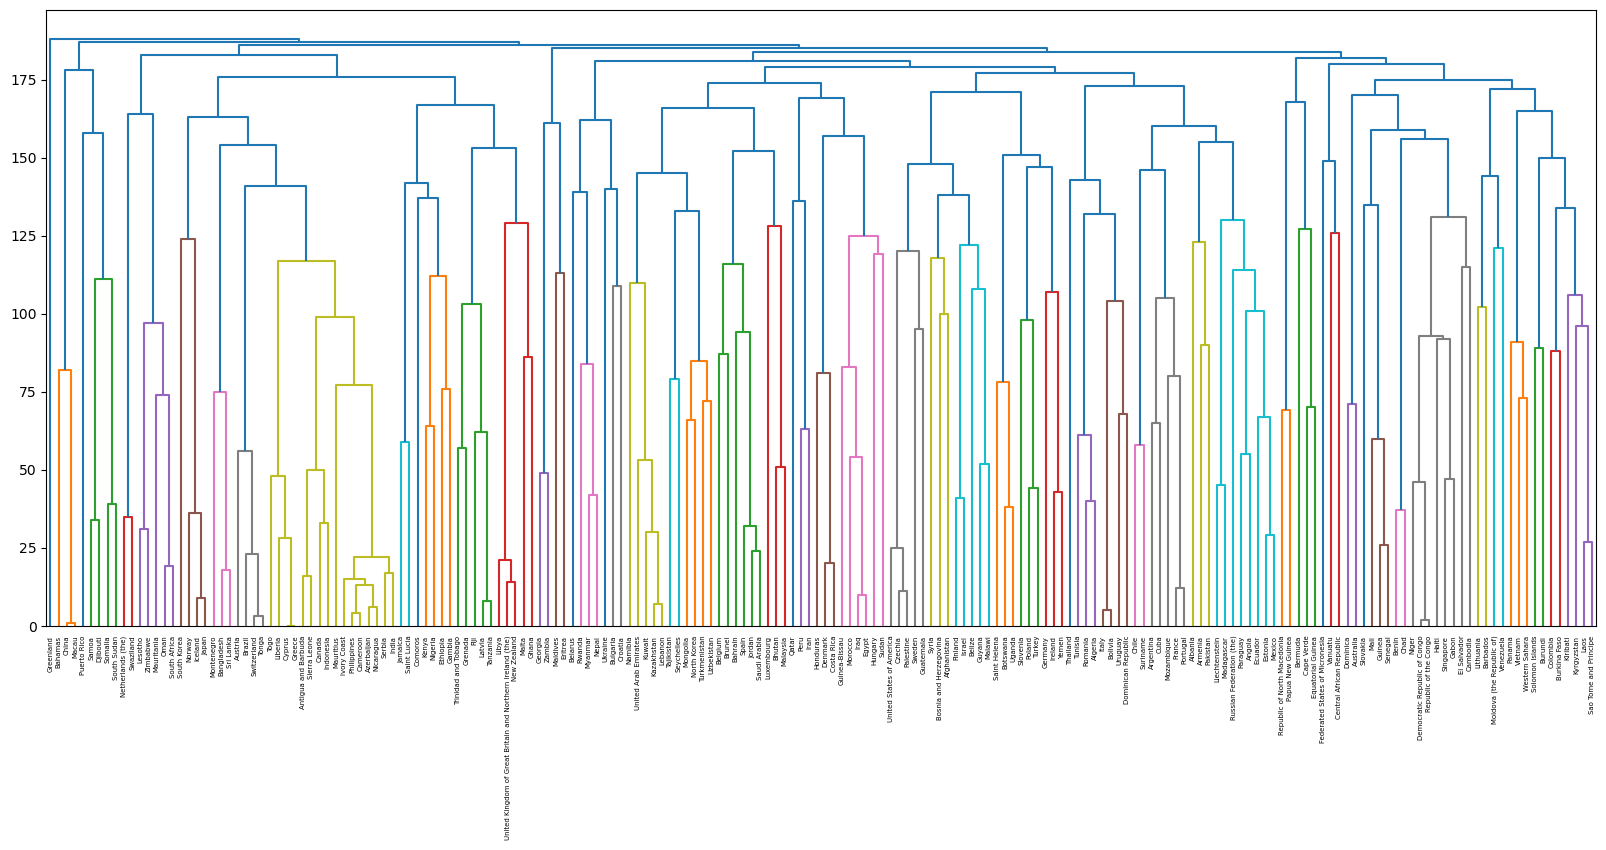

In [21]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0] + 2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize = (20, 8)) 
plot_dendrogram(model, labels = X.index, orientation='top')

After we zoom in the dendogram, we can draw some intresting conclusions. Some countries, which seem distant at first, appear to have very similiar anthems e.g. Switzerland and Tonga or Italy and Bolivia. One can also find other similarieties between other groups of countries.

In [22]:
print('Switzerland anthem:\n' , data.loc[data['Country'] == 'Switzerland', 'OriginalAnthem'].iloc[0])
print('')
print('Tonga anthem:\n' ,data.loc[data['Country'] == 'Tonga', 'OriginalAnthem'].iloc[0])

# We see that ineed, both Switzerland and Tonga's anthems are calls to the God which ask for blessings for their lands
# and hearing their prayers.

Switzerland anthem:
 When the morning skies grow red, and over us their radiance shed Thou, O Lord, appeareth in their light when the alps glow bright with splendor, pray to God, to Him surrender for you feel and understand that He dwelleth in this land. In the sunset Thou art night and beyond the starry sky Thou, O loving father, ever near, when to Heaven we are departing joy and bliss Thou'lt be imparting for we feel and understand that Thou dwellest in this land. When dark clouds enshroud the hills and gray mist the valley fills yet Thou art not hidden from thy sons pierce the gloom in which we cower with Thy sunshine's cleansing power then we'll feel and understand that God dwelleth in this land

Tonga anthem:
 Oh almighty God above Thou art our lord and sure defense As your people, we trust thee And our Tonga thou dost love Hear our prayer for thou unseen We know that thou hath blessed our land Grant our earnest supplication God save our king.


In [23]:
print('Italy anthem:\n' , data.loc[data['Country'] == 'Italy', 'OriginalAnthem'].iloc[0])
print('')
print('Bolivia anthem:\n' ,data.loc[data['Country'] == 'Bolivia', 'OriginalAnthem'].iloc[0])

# Here both Italy and Bolivia's anthems talk about fight for one's country and being prepared to die for it.

Italy anthem:
 Brothers of Italy, Italy has woken, bound Scipio's helmet Upon her head. Where is Victory? Let her bow down, Because slave of Rome God created her. Let us join in a cohort, we are ready to die. We are ready to die, Italy has called. Let us join in a cohort, We are ready to die. We are ready to die, Italy has called! Yes!

Bolivia anthem:
 Bolivians: favourable destiny Crowned our votes and desires It is now free, this land is now free And now its servile condition has ended From the military uproar that was yesterday And from the cry of the terrible war Today follow, in peaceful contrast Sweet hymns of peace and union Today follow, in peaceful contrast Sweet hymns of peace and union   Of the homeland, the lofty name In glorious splendour may we keep [it] And in its honour let's swear once again: To die before living as slaves! To die before living as slaves! To die before living as slaves!   Eternal praise to the brave warriors Whose heroic courage and determination Won 

## Summary & conclusions

To sum up this part of analysis:

Topic modelling for anthems did not bring very meaningful results. As predicted, most anthems focus on very similiar topics like nation and love for it, people, freedom etc. There were some topics identified, and one could find some differences, but they were not significant.

In k-means it was hard to find appropriate number of clusters, which might suggest that the data is not very clusterizable due to many similarietes. The best in my opinion was split into 4 clusters. In all of the cluster similiar words appeard, but I would argue that there were also minor differences. 

The hierarchical clustering gave the most interesting results, as it enabled us to see how similiar (close) are different anthems to each other and the analysis seemed to make sense.

## Additional exercise: sentiment analysis

Apart from exploring relationships between the anthems, we found it interesting to check whether we could try to assign positive or negative emotions to the anthems. We can suspect that anthems contain more words with positive rather than negative connotations (such as 'freedom', 'glory' etc.) as seen in topic analysis above.

As we do not have ability to train the model, we will use pre-trained VADER (valence based sentyment analyzer).



#### VADER

VADER is a valence based sentyment analyzer. It takes into account the "intensity" of a word as opposed to only the polarity. Suggested scale is positive for compound value >= 0.5, negative for <= -0.5 and neutral for anything in between.

In [24]:
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [25]:
# Let's compute the compound VADER scores

compval = [ ] # empty list to hold our computed 'compound' VADER scores

i = 0
while (i < len(data)):
    k = analyser.polarity_scores(data.iloc[i]['Anthem'])
    compval.append(k['compound'])
    i = i+1
    
# Convert sentiment values to numpy for easier usage
compval = np.array(compval)

In [26]:
data['VADER score'] = compval
data.head(10)

,Country,Continent,Anthem,OriginalAnthem,Topic,labels,VADER score
Country,,,,,,,
Albania,Albania,Europe,around our flag we stand united with one wish ...,"Around our flag we stand united, With one wish...",1,1,0.9740
Armenia,Armenia,Europe,our fatherland free independent that has for c...,"Our Fatherland, free, independent, That has fo...",1,1,0.9520
Austria,Austria,Europe,land of mountains land by the river land of fi...,"Land of mountains, land by the river, Land of ...",0,2,0.9871
Azerbaijan,Azerbaijan,Europe,azerbaijan azerbaijan the glorious fatherland ...,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",0,3,0.9834
Belarus,Belarus,Europe,we belarusians are peaceful people wholehearte...,"We, Belarusians, are peaceful people, Wholehea...",1,0,0.9968
Belgium,Belgium,Europe,o dear belgium o holy land of the fathers ã¢â‚...,"O dear Belgium, O holy land of the fathers Ã¢â...",0,0,0.9872
Bosnia and Herzegovina,Bosnia and Herzegovina,Europe,you re the light of the soul eternal fire s fl...,You're the light of the soul Eternal fire's fl...,0,0,0.6808
Bulgaria,Bulgaria,Europe,proud balkan mountains next to it the danube s...,"Proud Balkan Mountains, next to it the Danube ...",0,0,0.9860
Croatia,Croatia,Europe,our beautiful homeland oh so fearless and grac...,"Our beautiful homeland, Oh so fearless and gra...",0,0,0.9943


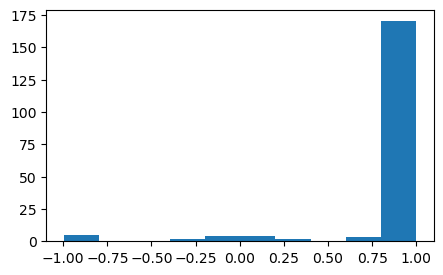

In [27]:
# Let's check the distribution of VADER scores.

fig, ax = plt.subplots(figsize =(5, 3))
ax.hist(data['VADER score'])
plt.show()

As expected, the vast majority of anthems was classified as (highly) positive.

In [28]:
# Let's check out the five anthems classified as most positive and see one of them.

data.nlargest(5, 'VADER score')

,Country,Continent,Anthem,OriginalAnthem,Topic,labels,VADER score
Country,,,,,,,
Turkey,Turkey,Asia,fear not for the crimson flag that proudly rip...,Fear not! For the crimson flag that proudly ri...,1,1,0.9990
Bolivia,Bolivia,South_America,bolivians favourable destiny crowned our votes...,Bolivians: favourable destiny Crowned our vote...,1,1,0.9989
Uruguay,Uruguay,South_America,orientals our nation or the grave liberty or w...,"Orientals, our nation or the grave, Liberty or...",0,1,0.9986
Zambia,Zambia,Africa,stand and sing of zambia proud and free land o...,"Stand and sing of Zambia, proud and free, Land...",0,2,0.9984
Paraguay,Paraguay,South_America,the peoples of the americas unfortunately were...,"The peoples of the Americas, unfortunately, We...",1,1,0.9982


In [29]:
for anthem in data.nlargest(1, 'VADER score').OriginalAnthem: 
    print(anthem, '/n')
    
# Indeed, Turkish anthem is full of positive words.

Fear not! For the crimson flag that proudly ripples in this glorious twilight, shall not fade, Before the last fiery hearth that is ablaze within my nation is extinguished. For That is the star of my nation, and it will forever shine; It is mine; and solely belongs to my valiant nation.Frown not, I beseech you, oh thou coy crescent, But smile upon my heroic race! Why the anger, why the rage? This blood of ours which we shed for you shall not be blessed otherwise; For Freedom is the absolute right of my God-worshiping nation.I have been free since the beginning and forever shall be so. What madman shall put me in chains! I defy the very idea! I'm like the roaring flood; powerful and independent, I'll tear apart mountains, exceed the heavens and still gush out! The lands of the West may be armored with walls of steel, But I have borders guarded by the mighty chest of a believer. Recognize your innate strength, my friend! And think: how can this fiery faith ever be killed, By that battere

In [30]:
# What about most negative anthems? There was only a handful of those.

data.nsmallest(5, 'VADER score')

,Country,Continent,Anthem,OriginalAnthem,Topic,labels,VADER score
Country,,,,,,,
Hungary,Hungary,Europe,o lord bless the nation of hungary with your g...,"O Lord, bless the nation of Hungary With your ...",0,0,-0.9955
Mexico,Mexico,North_America,mexicans at the cry of battle lend your swords...,"Mexicans, at the cry of battle lend your sword...",1,1,-0.9758
Ireland,Ireland,Europe,we ll sing a song a soldier s song with cheeri...,"We'll sing a song, a soldier's song With cheer...",0,2,-0.9618
Western Sahara,Western Sahara,Africa,o sons of the sahara in the battlefield you ar...,"O sons of the Sahara! In the battlefield, you ...",1,1,-0.9618
Palestine,Palestine,Asia,warrior warrior warrior oh my land the land of...,"Warrior, warrior, warrior, Oh my land, the lan...",1,2,-0.9432


In [31]:
for anthem in data.nsmallest(1, 'VADER score').OriginalAnthem: 
    print(anthem, '/n')

O Lord, bless the nation of Hungary With your grace and bounty Extend over it your guarding arm During strife with its enemies Long torn by ill fate Bring upon it a time of relief This nation has suffered for all sins Of the past and of the future! You brought our ancestors up Over the Carpathians' holy peaks By You was won a beautiful homeland For Bendeguz's sons And wherever flow the rivers of The Tisza and the Danube ÃƒÂrpÃƒÂ¡d our hero's descendants Will root and bloom For us on the plains of the Kuns You ripened the wheat In the grape fields of Tokaj You dripped sweet nectar Our flag you often planted On the wild Turk's earthworks And under MÃƒÂ¡tyÃƒÂ¡s' grave army whimpered Vienna's "proud fort." Ah, but for our sins Anger gathered in Your bosom And You struck with Your lightning From Your thundering clouds Now the plundering Mongols' arrows You swarmed over us Then the Turks' slave yoke We took upon our shoulders. How often came from the mouths Of Osman's barbarian nation Over 

In [32]:
# Hungary's anthem contains many 'scary' and 'negative' words like 'thundering',  'enemies', 'agress'. It is a song about
# suffering from violence. No wonder it was classified as negative.